<a href="https://www.kaggle.com/code/gautammdiwan/anime-face-generation-using-dcgan?scriptVersionId=95042619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## First, we import the libraries

In [1]:
%matplotlib inline
import random
import cv2
import torch
# import torch.nn as nn
# import torch.optim as optim
from torch import optim,nn
import torch.utils.data
import torchvision.datasets as dset
# import torchvision.transforms as transforms
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm

# Set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  42


### Here we define some important variables and hyperparameters

In [2]:
# Root directory for dataset
dataroot = "/kaggle/input/"

# Number of workers for dataloader
workers = 2

# Spatial size of training images to be resized using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

batch_size = 128

## Create and preview the dataset

CPU times: user 2.08 s, sys: 1.58 s, total: 3.66 s
Wall time: 52.8 s


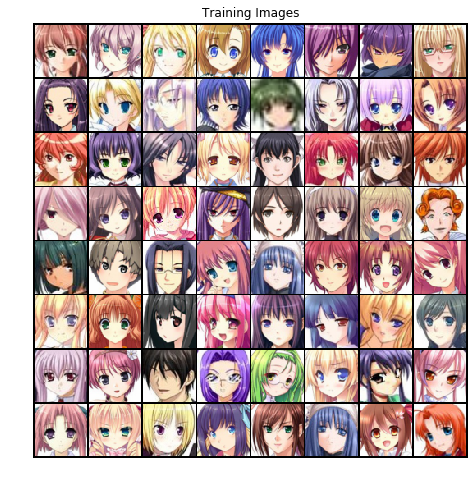

In [3]:
%%time
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Implementation

### Initialize weights

In [4]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Training

### Loss functions and Optimizers

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

### Begin training

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs),total=num_epochs):
    # For each batch in the dataloader
    for i, data in tqdm(enumerate(dataloader, 0),total=len(dataloader)):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item()}\tLoss_G: {errG.item()}\tD(x): {D_x}\tD(G(z)): {D_G_z1} / {D_G_z2}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % len(dataloader) == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


[0/50][0/497]	Loss_D: 1.646410346031189	Loss_G: 5.997228145599365	D(x): 0.6882314085960388	D(G(z)): 0.6237190365791321 / 0.003844598773866892



[1/50][0/497]	Loss_D: 1.0270484685897827	Loss_G: 6.994818210601807	D(x): 0.8625898957252502	D(G(z)): 0.4739272892475128 / 0.0022745849564671516



[2/50][0/497]	Loss_D: 1.1265010833740234	Loss_G: 8.668108940124512	D(x): 0.9491868615150452	D(G(z)): 0.5872166752815247 / 0.0006260037189349532



[3/50][0/497]	Loss_D: 0.6567729711532593	Loss_G: 7.582686424255371	D(x): 0.9655857682228088	D(G(z)): 0.4123803973197937 / 0.0009060598677024245



[4/50][0/497]	Loss_D: 0.38745245337486267	Loss_G: 3.706465482711792	D(x): 0.7615988850593567	D(G(z)): 0.025752516463398933 / 0.04648124426603317



[5/50][0/497]	Loss_D: 0.3747555911540985	Loss_G: 6.377549171447754	D(x): 0.9183146357536316	D(G(z)): 0.2199021577835083 / 0.0028451350517570972



[6/50][0/497]	Loss_D: 2.8113532066345215	Loss_G: 10.65107536315918	D(x): 0.9951212406158447	D(G(z)): 0.8607635498046875 / 0.0002861105604097247



[7/50][0/497]	Loss_D: 0.2220609039068222	Loss_G: 4.09475564956665	D(x): 0.8837750554084778	D(G(z)): 0.06912042200565338 / 0.034388065338134766



[8/50][0/497]	Loss_D: 0.7450140118598938	Loss_G: 2.472207546234131	D(x): 0.5860093235969543	D(G(z)): 0.008358156308531761 / 0.14755721390247345



[9/50][0/497]	Loss_D: 0.3705647885799408	Loss_G: 5.629448890686035	D(x): 0.9417340755462646	D(G(z)): 0.23441851139068604 / 0.0065133096650242805



[10/50][0/497]	Loss_D: 0.488815575838089	Loss_G: 6.578245162963867	D(x): 0.954821765422821	D(G(z)): 0.323585569858551 / 0.0022425204515457153



[11/50][0/497]	Loss_D: 1.4822893142700195	Loss_G: 11.550068855285645	D(x): 0.9965733289718628	D(G(z)): 0.6779714226722717 / 3.753736746148206e-05



[12/50][0/497]	Loss_D: 0.4877840280532837	Loss_G: 4.916473865509033	D(x): 0.9105582237243652	D(G(z)): 0.2851967215538025 / 0.012273849919438362



[13/50][0/497]	Loss_D: 0.24523098766803741	Loss_G: 3.7147536277770996	D(x): 0.893024206161499	D(G(z)): 0.11082744598388672 / 0.039139118045568466



[14/50][0/497]	Loss_D: 0.3258458971977234	Loss_G: 4.0299072265625	D(x): 0.9356701374053955	D(G(z)): 0.19684189558029175 / 0.030484527349472046



[15/50][0/497]	Loss_D: 0.5103453993797302	Loss_G: 5.821875095367432	D(x): 0.9763084650039673	D(G(z)): 0.3375360071659088 / 0.0051104663871228695



[16/50][0/497]	Loss_D: 0.8988978862762451	Loss_G: 6.860027313232422	D(x): 0.983906626701355	D(G(z)): 0.5037823915481567 / 0.0019259469117969275



[17/50][0/497]	Loss_D: 0.3056519031524658	Loss_G: 2.203734874725342	D(x): 0.8081837296485901	D(G(z)): 0.06679542362689972 / 0.14874610304832458



[18/50][0/497]	Loss_D: 0.32083433866500854	Loss_G: 3.0037450790405273	D(x): 0.834290623664856	D(G(z)): 0.11187325417995453 / 0.07378461956977844



[19/50][0/497]	Loss_D: 0.46135762333869934	Loss_G: 5.469862937927246	D(x): 0.9900892376899719	D(G(z)): 0.32611680030822754 / 0.0069688428193330765



[20/50][0/497]	Loss_D: 0.3441384434700012	Loss_G: 4.4901227951049805	D(x): 0.9220851063728333	D(G(z)): 0.20687969028949738 / 0.017839938402175903



[21/50][0/497]	Loss_D: 0.425538569688797	Loss_G: 2.047010898590088	D(x): 0.7648276090621948	D(G(z)): 0.1078416258096695 / 0.18734733760356903



[22/50][0/497]	Loss_D: 0.2883012890815735	Loss_G: 4.091157913208008	D(x): 0.8996742963790894	D(G(z)): 0.14127281308174133 / 0.02754194289445877



[23/50][0/497]	Loss_D: 0.163291797041893	Loss_G: 3.752035140991211	D(x): 0.9223531484603882	D(G(z)): 0.07178543508052826 / 0.03735525533556938



[24/50][0/497]	Loss_D: 0.16134999692440033	Loss_G: 3.837066173553467	D(x): 0.9141652584075928	D(G(z)): 0.06091766059398651 / 0.03640108183026314



[25/50][0/497]	Loss_D: 0.27091196179389954	Loss_G: 3.6617062091827393	D(x): 0.9175786375999451	D(G(z)): 0.1521417498588562 / 0.03686299920082092



[26/50][0/497]	Loss_D: 0.30142924189567566	Loss_G: 3.6564557552337646	D(x): 0.8634470701217651	D(G(z)): 0.12421184778213501 / 0.039085131138563156



[27/50][0/497]	Loss_D: 0.8671633005142212	Loss_G: 1.7207705974578857	D(x): 0.7462798357009888	D(G(z)): 0.33977192640304565 / 0.28205037117004395



[28/50][0/497]	Loss_D: 1.1466131210327148	Loss_G: 1.189626932144165	D(x): 0.4648180603981018	D(G(z)): 0.2035297155380249 / 0.39852452278137207



[29/50][0/497]	Loss_D: 0.45341333746910095	Loss_G: 3.9689483642578125	D(x): 0.9808850288391113	D(G(z)): 0.3244834244251251 / 0.02696945145726204



[30/50][0/497]	Loss_D: 0.14608636498451233	Loss_G: 4.790066242218018	D(x): 0.9630246162414551	D(G(z)): 0.09594444185495377 / 0.01448915433138609



[31/50][0/497]	Loss_D: 0.1540219485759735	Loss_G: 4.710598945617676	D(x): 0.9774584770202637	D(G(z)): 0.11205741763114929 / 0.014691191725432873



[32/50][0/497]	Loss_D: 0.09016426652669907	Loss_G: 4.562112808227539	D(x): 0.9371892809867859	D(G(z)): 0.02116912230849266 / 0.021168652921915054



[33/50][0/497]	Loss_D: 0.11924922466278076	Loss_G: 4.336657524108887	D(x): 0.9368836283683777	D(G(z)): 0.046089254319667816 / 0.025972310453653336



[34/50][0/497]	Loss_D: 0.0794634073972702	Loss_G: 3.6972484588623047	D(x): 0.9545211791992188	D(G(z)): 0.0296584814786911 / 0.04051364213228226



[35/50][0/497]	Loss_D: 0.13732321560382843	Loss_G: 2.9807000160217285	D(x): 0.9011200666427612	D(G(z)): 0.02592950128018856 / 0.08680984377861023



[36/50][0/497]	Loss_D: 0.28830036520957947	Loss_G: 2.7157609462738037	D(x): 0.8042269945144653	D(G(z)): 0.017025813460350037 / 0.11649525165557861



[37/50][0/497]	Loss_D: 1.2335902452468872	Loss_G: 5.940679550170898	D(x): 0.9870189428329468	D(G(z)): 0.6217679977416992 / 0.005362893920391798



[38/50][0/497]	Loss_D: 0.11057325452566147	Loss_G: 3.9045557975769043	D(x): 0.9295336008071899	D(G(z)): 0.03109910897910595 / 0.033765025436878204



[39/50][0/497]	Loss_D: 0.3692638576030731	Loss_G: 8.341712951660156	D(x): 0.9973154664039612	D(G(z)): 0.27660977840423584 / 0.0003808116016443819



[40/50][0/497]	Loss_D: 0.6055393218994141	Loss_G: 2.7595784664154053	D(x): 0.6223092079162598	D(G(z)): 0.04494326561689377 / 0.10709955543279648



[41/50][0/497]	Loss_D: 0.04910891503095627	Loss_G: 4.654057025909424	D(x): 0.9763434529304504	D(G(z)): 0.024173803627490997 / 0.01649036630988121



[42/50][0/497]	Loss_D: 0.1527317464351654	Loss_G: 4.528643608093262	D(x): 0.9704844951629639	D(G(z)): 0.10749973356723785 / 0.019427429884672165



[43/50][0/497]	Loss_D: 0.08628155291080475	Loss_G: 5.612175941467285	D(x): 0.9830148816108704	D(G(z)): 0.06072983890771866 / 0.006734177935868502



[44/50][0/497]	Loss_D: 0.07002271711826324	Loss_G: 4.849766254425049	D(x): 0.9620356559753418	D(G(z)): 0.0290568545460701 / 0.014336277730762959



[45/50][0/497]	Loss_D: 0.1824110597372055	Loss_G: 4.561357021331787	D(x): 0.9325412511825562	D(G(z)): 0.09109605848789215 / 0.021412968635559082



[46/50][0/497]	Loss_D: 0.05425020307302475	Loss_G: 5.26436185836792	D(x): 0.9817786812782288	D(G(z)): 0.03340447321534157 / 0.009174454025924206



[47/50][0/497]	Loss_D: 0.3105088770389557	Loss_G: 3.933987855911255	D(x): 0.8619651198387146	D(G(z)): 0.11703270673751831 / 0.04063665121793747



[48/50][0/497]	Loss_D: 0.06595545262098312	Loss_G: 5.596117973327637	D(x): 0.9914203882217407	D(G(z)): 0.05000855773687363 / 0.007657558657228947



[49/50][0/497]	Loss_D: 0.2118760198354721	Loss_G: 3.9224820137023926	D(x): 0.9568296074867249	D(G(z)): 0.1263338178396225 / 0.04205217957496643




# Results

### Loss plot

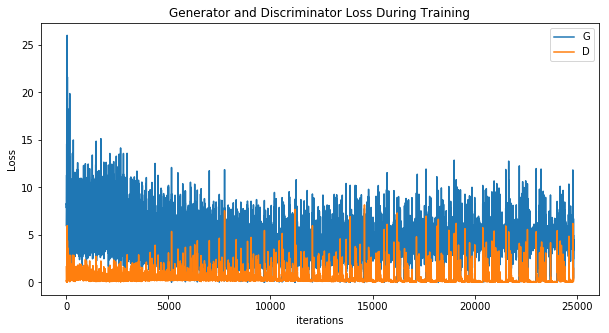

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Training process

In [12]:
vid_fname = './gans_training.mp4'

# 5 is the fps, 530, 530 is the size
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
# cv2 requires numpy arrays with int pixel values from 0 to 255 in the BGR color space
[out.write(cv2.cvtColor((i.permute(1,2,0)*255).numpy().astype('uint8'),cv2.COLOR_RGB2BGR)) for i in img_list]
out.release()

In [17]:
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=1000, blit=True)
# HTML(ani.to_jshtml())

# Final Results

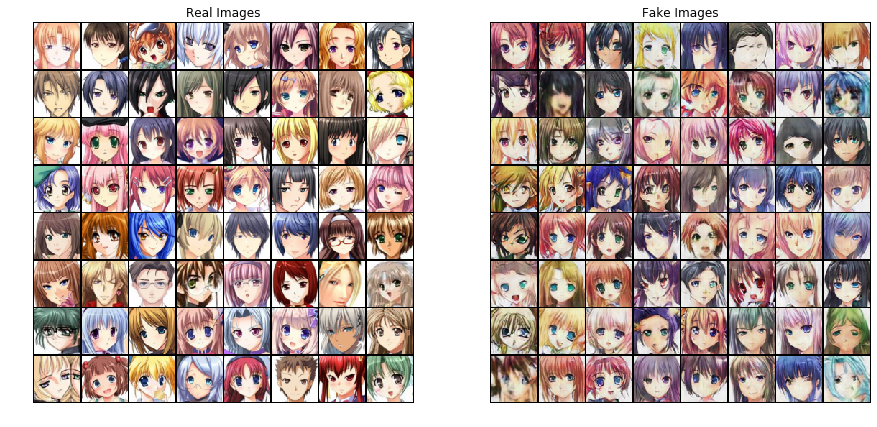

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu().permute(1,2,0))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-1].permute(1,2,0))
plt.show()

In [15]:
torch.save(netG.state_dict(), 'Generator.pt')
torch.save(netD.state_dict(), 'Discriminator.pt')